$$
\newcommand{\pd}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bx}[2]{\mathbf{x}_{#1}^{\mathrm{#2}}}
\newcommand{\by}[1]{\mathbf{y}_{#1}}
\newcommand{\bw}[2]{\mathbf{w}_{#1}^{\mathrm{#2}}}
\newcommand{\dbp}[2]{\delta\mathbf{p}_{#1}^{\mathrm{#2}}}
$$
# Lorenzモデル

Lorenz (1963){cite}`Lorenz:1963`のモデル（以下Lorenz-63）は熱対流を理想化したモデルで，パラメタ次第でカオスにふるまいます。Lorenz-63は次の3変数の常微分方程式で表されます。

$$
\begin{aligned}
\dot{X} &= -\sigma X + \sigma Y \\
\dot{Y} &= -XZ + rX -Y \\
\dot{Z} &= XY - \beta Z \label{l63}
\end{aligned}
$$ (l63)

パラメタ$\sigma$, $r$, $\beta$ はそれぞれPrandtl数，変形されたRayleigh数，アスペクト比を表しています。
予報変数$X, Y, Z$はそれぞれ無次元化された対流の強さ，最大温度差，対流に伴う成層の変化を表すものです。
左辺の変数の上の$\cdot$は時間微分$\mathrm{d}/\mathrm{d}t$を表す記号です。

　Lorenz-63を使って，まず変分法を用いて観測を同化して最適な初期値を求めてみましょう。次にアンサンブルカルマンフィルタを用いた逐次データ同化に取り組みます。最後にニューラルネットワークを使って教師データからモデルを推定します。

## 変分法

変分法データ同化では，同化ウィンドウ（同化窓）と呼ばれる期間に観測されたデータ近づくように初期状態を修正します。
同化ウインドウにおける場の状態は予報モデルを時間積分することにより求めます。
空間3次元と時間1次元の4次元に対する同化を行うことから，4次元変分法（4DVar）と呼ばれています。
Lorenz-63モデルの場合は空間は1点ですが，手法の名前として4DVarを用います。

初期値の推定精度の指標となるスカラー函数を評価函数またはコスト函数と呼び，$J$で表します。
評価函数が最小になる推定値が最適な初期値です。
最適な初期値を推定するためには，初期値に摂動を与えたときに評価函数がどれくらい変化するかという情報，つまり初期値に対する評価函数の勾配$\nabla J$が必要です。
勾配が求まれば，$\nabla J=0$を数値最適化手法を用いて求めることが可能です。

In [148]:
p, r, b, dt = 10, 32, 8/3, 0.01
nstop = 200
obs_int = 60

rng = np.random.default_rng()
w = np.array([1.0, 3.0, 5.0])
e = w * 0.1
x_obs = np.zeros([nstop//obs_int+1, w.size])
x = np.zeros([nstop+1, w.size])
for i in range(nstop+1):
    w += dt * florenz(w, p, r, b)
    if i % obs_int == 0:
        x_obs[i//obs_int, :] = w# + e * rng.standard_normal(w.size)
    x[i, :] = w
np.save("xt.npy", x)

niter = 100
alpha = 5e-4

w = np.array([1.0, -3.0, 5.0])
ad = np.zeros(w.size)
dad = np.zeros(w.size)
cost = np.zeros([niter])
cycles = [1, 2, 5, 10, 30, 50, 100]

x, cost[0] = run_florenz(w, x_obs, p, r, b)

for j in range(niter):
    ad[:] = 0.0
    for i in range(nstop, 0, -1):
        if i % obs_int == 0:
            ad += x[i, :] - x_obs[i//obs_int, :]
        dad += dt * ad
        ad, dad = alorenz(ad, dad, x[i, :], p, r, b)
    w = x[0, :] - alpha * ad
    x, cost[j] = run_florenz(w, x_obs, p, r, b)
    if j+1 in cycles:
        np.save(f"x{j+1:03}.npy", x)

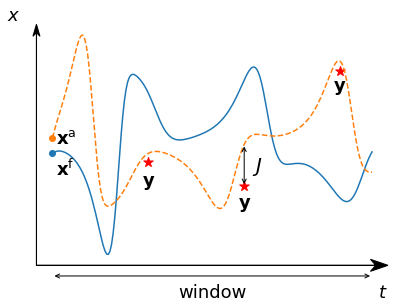

In [237]:
import matplotlib.pyplot as plt

x = np.linspace(0, dt * nstop, nstop+1)
xobs = np.arange(obs_int, nstop, obs_int) * dt
                           
fig, ax = plt.subplots(figsize=[7, 5])
wobs = np.copy(x_obs)

w = np.load(f"x001.npy")
ax.plot(x, w[:, 1], label="guess")
ax.scatter(0, w[0, 1], marker="o")
w = np.load(f"x100.npy")
ax.plot(x, w[:, 1], linestyle="--", label="updated")
ax.scatter(0, w[0, 1], marker="o")
ax.scatter(xobs, wobs[1:,1], c="red", marker="*", s=100, label="obs")
ax.text(0.02, -9, "$\mathbf{x}^\mathrm{f}$", size=18)
ax.text(0.02, 0, "$\mathbf{x}^\mathrm{a}$", size=18)
ax.annotate(text="", xy=(xobs[1], wobs[2, 1]), xytext=(xobs[1], w[2*obs_int, 1]),
            arrowprops=dict(arrowstyle="<->"))
ax.text(1.25, -8, "$J$", size=20)
yobs = [-12, -18, 15]
for i in range(xobs.size):
    ax.text(xobs[i], yobs[i], "$\mathbf{y}$", ha="center", size=18)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.spines[:].set_visible(False)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
dx = (xmax - xmin)
dy = (ymax - ymin)
lw = 1.0
ohg = 0.3
ax.arrow(xmin, ymin, dx, 0, color="k",
        head_width=dy*0.05, head_length=dx*0.05, overhang=ohg,
        length_includes_head=True, clip_on=False)
ax.arrow(-0.1, ymin, 0, dy, color="k",
        head_width=dx*0.02, head_length=dy*0.05, overhang=ohg,
        length_includes_head=True, clip_on=False)
ax.annotate(text="", xy=(0, ymin-3), xytext=(2, ymin-3),
            arrowprops=dict(arrowstyle="<->"))
ax.text(1, ymin-10, "window", ha="center", va="bottom", size=18)
ax.text(-0.2, ymax, "$x$", ha="right", va="bottom", size=18)
ax.text(xmax, ymin-10, "$t$", ha="right", va="bottom", size=18)
plt.show()

ここでは簡単のため予報される場所で観測も行われるものとし，評価函数は予報の観測からの乖離

$$
J = \frac{1}{2}\sum_{k=0}^{n}(\bx{k}{f}-\by{k})^T(\bx{k}{f}-\by{k})
$$ (cost)

で表すことにします。
$\bx{k}{f}, \by{k}$はそれぞれステップ$k$での予報$\mathrm{f}$と観測を表しています。
背景誤差共分散$\mathbf{B}$と観測誤差共分散$\mathbf{R}$が与えられた場合は

$$
J = \frac{1}{2}(\bx{0}{}-\bx{0}{f})^T\mathbf{B}^{-1}(\bx{0}{}-\bx{0}{f}) + \frac{1}{2}\sum_{k=0}^{n}(\by{k}-\mathbf{H}\bx{k}{f})^T\mathbf{R}^{-1}(\by{k}-\mathbf{H}\bx{k}{f})
$$ (costbr)

を評価関数とすることもできます。

勾配を効率的に求めるために，随伴モデルが用いられます。
随伴モデルは，モデルを基本場の周りに線型化したモデル（接線型モデル）を行列で表したとき転置して得られるものです。
非線型のモデルを$\mathcal{M}$で表すと，ステップ$k-1$から$k$への時間発展は

$$
\bx{k}{f} = \mathcal{M}\left(\bx{k-1}{f}\right)
$$ (nonlinear)

と表すことができます。

摂動を与えた$\bx{k}{f} + \delta\bx{k}{f}$の時間発展から摂動なしの時間発展を引き，摂動の2次以上の項を無視すると摂動の時間発展

$$
\delta\bx{k}{f} = \pd{\mathcal{M}\left(\bx{k-1}{f}\right)}{\bx{k-1}{f}}\delta\bx{k-1}{f} = \mathbf{L}\left(\bx{k-1}{f}\right)\delta\bx{k-1}{f}
$$ (TLM)

が得られます。
$\mathbf{L}$は接線型モデルを表す線型演算子です。

接線型演算子を繰り返し用いることにより $\delta\bx{k}{f}$ と$\delta\bx{0}{f}$の関係を次のように表すことができます。

$$
\delta\bx{k}{f} = \mathbf{L}\left(\bx{k-1}{f}\right)\mathbf{L}\left(\bx{k-2}{f}\right)\cdots\mathbf{L}\left(\bx{0}{f}\right)\delta\bx{0}{f} = \mathbf{L}_k\delta\bx{0}{f} \label{Lk}
$$ (Lk)

一方，評価函数{eq}`cost`の勾配は

$$
\left[\nabla J(\bx{0}{f})\right]^T\delta\bx{0}{f} = \sum_k(\bx{k}{f}-\by{k})^T\delta\bx{k}{f}
$$ (grad)

と表すことができるので，勾配は

$$
\nabla J(\bx{0}{f}) = \sum_k\mathbf{L}_k^T\left(\bx{k}{f}-\by{k}\right)
$$ (nablaJ)

から求めることができます。

ここで接線型演算子の転置

$$
\mathbf{L}_k^T = \mathbf{L}^T\left(\bx{0}{f}\right)\mathbf{L}^T\left(\bx{1}{f}\right)\cdots\mathbf{L}^T\left(\bx{k-2}{f}\right)\mathbf{L}^T\left(\bx{k-1}{f}\right)
$$ (LT)

は随伴モデルを表す演算子です。

{eq}`nablaJ`は観測からの乖離に随伴演算子を作用させながら，時間逆方向に$0$まで和を取ることにより得られることを示しています。

:::{admonition} 4DVarによるデータ同化
1. 非線型モデルを実行し，途中の結果を保存しておく。
2. 同化ウィンドウの終わりから初期時刻に向かって随伴モデルを積分し勾配を計算する。
3. 勾配を用いて数値最適化を行い，初期値を更新する。
4. 勾配が閾値を下回るか，最大の繰り返し回数を超えたら終了。そうでなけれぱ1に戻る。
:::

## Pythonコード

Lorenz-63の非線型モデル{eq}`l63`，接線型モデル，随伴モデル{cite}`Huang-Yang:1996`をPythonで書いてみましょう。
Prandtl数，Rayleigh数，アスペクト比はそれぞれ`p`, `r`, `b`で表されています。
`x, y, z = w`のように1次元配列を展開して式との対応がつきやすいように工夫しています。
わずかに異なる初期値から積分してみると，一方はアトラクタと呼ばれる点の周りを周回しているのに対し，もう一方は別のアトラクタの周りに動いていったことが分かります。

In [6]:
def florenz(w, p, r, b):
    x, y, z = w
    dw = np.zeros_like(w)
    dw[0] =      -p * x + p * y 
    dw[1] = (r - z) * x -     y 
    dw[2] =           x * y     - b * z
    return dw

In [7]:
import numpy as np


p, r, b, dt = 10, 32, 8/3, 0.01
nstop = 500

w1 = np.zeros([nstop+1, 3])
w2 = np.zeros([nstop+1, 3])
w1[0, :] = 1, 3, 5
w2[0, :] = 1.1, 3.3, 5.5
for i in range(nstop):
    w1[i+1, :] = w1[i, :] + dt * florenz(w1[i, :], p, r, b)
    w2[i+1, :] = w2[i, :] + dt * florenz(w2[i, :], p, r, b)    

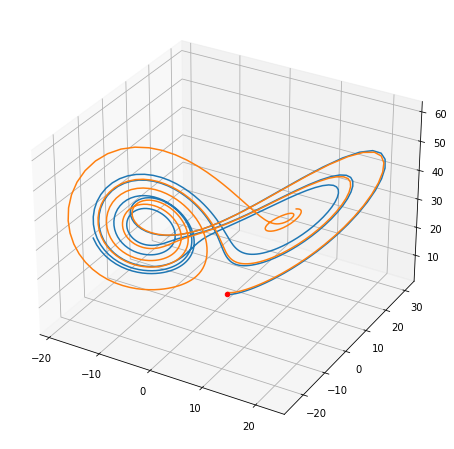

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(projection="3d")
ax.scatter(*w1[0, :], c="red")
ax.plot(*w1.transpose())
ax.plot(*w2.transpose())
plt.show()

3つの変数を少しずらして描画してみます。

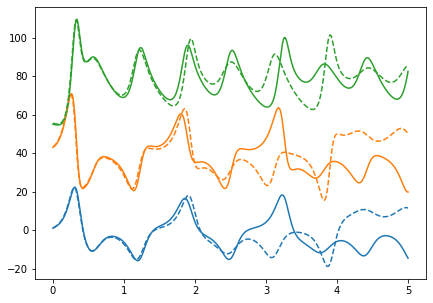

In [5]:
import matplotlib.pyplot as plt

off1, off2 = 40, 50

x = np.linspace(0, dt*nstop, nstop+1)
w = np.copy(w1)
w[:, 1] += off1
w[:, 2] += off2
fig, ax = plt.subplots(figsize=[7,5])
ax.plot(x, w)
plt.gca().set_prop_cycle(None)
w = np.copy(w2)
w[:, 1] += off1
w[:, 2] += off2
ax.plot(x, w, linestyle="--")
plt.show()

接線型モデルは非線型項を線型化して求めます。
二つの変数の積，例えば$\dot{Z}$の式の$XY$は$\delta XY+X\delta Y$のように二つの項に分かれます。
上述の手順では接線型モデルは使いませんが，接線型モデルを使う定式化もあります。

In [9]:
def tlorenz(wt, wb, p, r, b):
    dw = np.zeros_like(wt)
    xt, yt, zt = wt
    xb, yb, zb = wb
    dw[0] =       -p * xt +  p * yt 
    dw[1] = (r - zb) * xt -      yt - xb * zt
    dw[2] =       yb * xt + xb * yt -  b * zt
    return dw

随伴モデルは接線型モデルの転置として表されます。
随伴モデルの変数は0に初期化します。
随伴モデルを用いて積分を行うときは，各ステップで観測からの乖離を積算していきます。
随伴モデルの最後に時間変化は0にします。

In [55]:
def alorenz(wa, dwa, wb, p, r, b):
    xb, yb, zb = wb
    dxa, dya, dza = dwa
    wa[0] += -p * dxa + (r - zb) * dya + yb * dza
    wa[1] +=  p * dxa -            dya + xb * dza
    wa[2] +=          -       xb * dya -  b * dza
    dwa[:] = 0.0
    return wa, dwa

観測を真値に誤差を加えて作ります。観測の間隔は60ステップとします。誤差は正規分布に従い，標準偏差は初期値の10%とします。

In [375]:
p, r, b, dt = 10, 32, 8/3, 0.01
nstop = 200
obs_int = 60

rng = np.random.default_rng()
w = np.array([1.0, 3.0, 5.0])
e = w * 0.1
x_obs = np.zeros([nstop//obs_int, w.size])
x_obs[0, :] = w
x = np.zeros([nstop+1, w.size])
for i in range(1, nstop+1):
    w += dt * florenz(w, p, r, b)
    if i % obs_int == 0:
        x_obs[i//obs_int-1, :] = w + e * rng.standard_normal(w.size)
    x[i, :] = w
np.save("xt.npy", x)

随伴計算では改善した初期値から繰り返し予報をするので，予報と評価函数の計算をする関数を定義しておきます。

In [376]:
def run_florenz(w, xo, p, r, b):
    x = np.zeros([nstop+1, w.size])
    x[0, :] = w
    c = 0
    for i in range(1, nstop+1):
        w += dt * florenz(w, p, r, b)
        x[i, :] = w
        if i % obs_int == 0:
            c += ((w - xo[i//obs_int-1, :])**2).sum()
    c *= 0.5
    return x, c

最急降下法で同化を試みます。最大反復回数は100回，ステップ幅$5\times 10^{-4}$とします。

In [380]:
niter = 100
alpha = 5e-4

w = np.array([1.1, 3.3, 5.5])
ad = np.zeros(w.size)
dad = np.zeros(w.size)
cost = np.zeros([niter])
cycles = [1, 2, 3, 5, 10, 30]

x, cost[0] = run_florenz(w, x_obs, p, r, b)

for j in range(niter):
    ad[:] = 0.0
    for i in range(nstop, 0, -1):
        if i % obs_int == 0 and i > 0:
            ad += x[i, :] - x_obs[i//obs_int-1, :]
        dad += dt * ad
        ad, dad = alorenz(ad, dad, x[i, :], p, r, b)
    w = x[0, :] - alpha * ad
    x, cost[j] = run_florenz(w, x_obs, p, r, b)
    if j+1 in cycles:
        np.save(f"x{j+1:03}.npy", x)

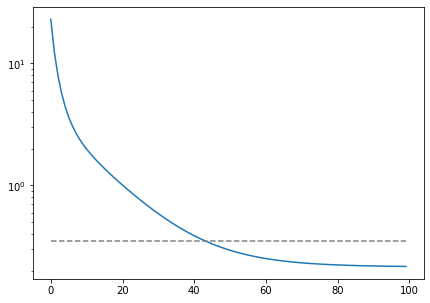

In [381]:
fig, ax = plt.subplots(figsize=[7, 5])
ax.semilogy(cost)
ax.plot([np.dot(e, e)]*cost.size, c="gray", linestyle="--")
plt.show()

最適化1, 2, 3, 5, 10, 30サイクルで真値（波線）に徐々に近づいていく様子を確認しましょう。

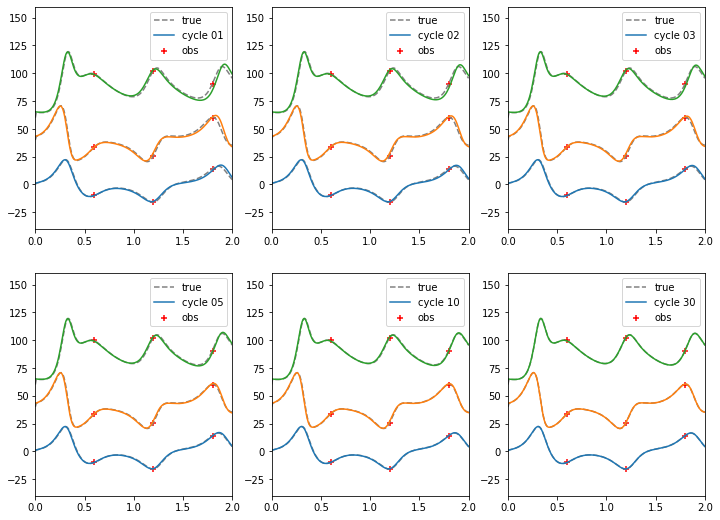

In [383]:
x = np.linspace(0, dt * nstop, nstop+1)
xobs = np.arange(obs_int, nstop, obs_int) * dt

nx, ny = 2, 3           
off1, off2 = 40, 60                              
fig, ax = plt.subplots(nx, ny, figsize=[12, 9])
wtrue = np.load("xt.npy")
wtrue[:, 1] += off1            
wtrue[:, 2] += off2
wobs = np.copy(x_obs)

wobs[:, 1] += off1
wobs[:, 2] += off2

k = 0
for ncyc in cycles:
    i, j = k // ny, k % ny
    k += 1
    w = np.load(f"x{ncyc:03}.npy")
    w[:, 1] += off1
    w[:, 2] += off2
    ax[i, j].plot(x, wtrue, c="gray", linestyle="--", label=["true","",""])
    ax[i, j].plot(x, w, label=[f"cycle {ncyc:02}","",""])
    ax[i, j].scatter(xobs, wobs[:,0], c="red", marker="+", label="obs")
    ax[i, j].scatter(xobs, wobs[:,1], c="red", marker="+")
    ax[i, j].scatter(xobs, wobs[:,2], c="red", marker="+")
    ax[i, j].set_xlim([0.0, 2.0])
    ax[i, j].set_ylim([-40, 160])
    ax[i, j].legend(loc="upper right")
    ax[i, j].set_prop_cycle(None)
plt.show()

## アンサンブルカルマンフィルタ

アンサンブルカルマンフィルタは変分法と並んで広く使われているデータ同化手法です。
変分法が最適制御理論に基づいているのに対し，アンサンブルカルマンフィルタは統計的推定論を理論的な背景としています。

### ベイズの定理

統計的推定論からみたデータ同化の問題とは，事前に分かっている場の確率密度函数（pdf, probability distribution function）と観測のpdfから観測が得られたときの場の事後pdfを求めることです。
これらのpdf同士の関係はベイズの定理で表されます。

$$
P(\mathbf{x}|\mathbf{y}) = \frac{P(\mathbf{y}|\mathbf{x})P(\mathbf{x})}{P(\mathbf{y})}
$$ (bayes)

$\mathbf{x}$を場の状態ベクトル，$\mathbf{y}$を観測としたとき，$P(\mathbf{x})$と$P(\mathbf{y})$はそれぞれ場，観測のpdfを表しています。
分母の$P(\mathbf{y})$は規格化を行っており，重要ではありません。
一方，$P(\mathbf{y}|\mathbf{x})$は場の状態$\mathbf{x}$を測定する場合のpdfで，$P(\mathbf{y}|\mathbf{x})\mathrm{d}\mathbf{y}$の積分は条件付き確率を表しています。
左辺の$P(\mathbf{x}|\mathbf{y})$は測定が行われ観測が与えられた条件の下での事後確率を表しています。
ベイズの定理は，場の状態が$\mathbf{x}$で観測が$\mathbf{y}$であるpdf

$$
P(\mathbf{x}, \mathbf{y}) = P(\mathbf{y}|\mathbf{x})P(\mathbf{x}) = P(\mathbf{x}|\mathbf{y})P(\mathbf{y})
$$

から直ちに導出することができます。
ベイズの定理は，場の事前pdfを観測のpdfで更新することによって，観測が得られたときの事後確率を計算するものです。

#### カルマンゲイン

状態と観測の確率密度が共にガウス型

$$
\begin{align}
P(\mathbf{x}) &\propto \exp\left[-\frac{1}{2}(\mathbf{x}-\mathbf{x}^\mathrm{f})^T\mathbf{P}_\mathrm{f}^{-1}(\mathbf{x}-\mathbf{x}^\mathrm{f})\right] \nonumber\\
P(\mathbf{y}|\mathbf{x}) &\propto \exp\left[-\frac{1}{2}(\mathbf{y}-\mathbf{Hx})^T\mathbf{R}^{-1}(\mathbf{y}-\mathbf{Hx})\right]
\end{align}
$$

で表されると仮定します。
対数をとってベイズの定理(\ref{bayes})を適用すると

$$
-\ln P(\mathbf{x}|\mathbf{y}) = \frac{1}{2}(\mathbf{x}-\mathbf{x}^\mathrm{f})^T\mathbf{P}_\mathrm{f}^{-1}(\mathbf{x}-\mathbf{x}^\mathrm{f}) + \frac{1}{2}(\mathbf{y}-\mathbf{Hx})^T\mathbf{R}^{-1}(\mathbf{y}-\mathbf{Hx})
$$ (lnP)

が得られます。
(\ref{lnP})は背景誤差共分散$\mathbf{B}$を予報誤差共分散$\mathbf{P}_\mathrm{f}$で近似した評価関数{eq}`cost`にほかなりません。
最適推定値を$\mathbf{x}^\mathrm{a}$，解析誤差共分散を$\mathbf{P}_\mathrm{a}$とし，事後の確率密度にもガウス型を仮定すると

$$
-\ln P(\mathbf{x}|\mathbf{y}) = \frac{1}{2}(\mathbf{x}-\mathbf{x}^\mathrm{a})^T\mathbf{P}_\mathrm{a}^{-1}(\mathbf{x}-\mathbf{x}^\mathrm{a})
$$ (lnPa)

{eq}`lnP`及び{eq}`lnPa`の$\mathbf{x}$の2次の項から

$$
\mathbf{P}_\mathrm{a}^{-1} = \mathbf{H}^T\mathbf{R}^{-1}\mathbf{H} + \mathbf{P}_\mathrm{f}^{-1}
$$ (Pa)

$\mathbf{x}^T$の1次の項から

$$
\mathbf{x}^\mathrm{a} = \mathbf{x}^\mathrm{f} + \mathbf{K}(\mathbf{y}-\mathbf{H}\mathbf{x}^\mathrm{f})
$$ (xa)

が得られます。
ここで

$$
\mathbf{K} = (\mathbf{H}^T\mathbf{R}\mathbf{H} + \mathbf{P}^\mathrm{f})^{-1}\mathbf{HR}^{-1}
$$ (n-form)

をカルマンゲインといいます。
$$
\mathbf{H}^T\mathbf{R}^{-1}(\mathbf{R} + \mathbf{HP}_\mathrm{f}\mathbf{H}^T)=(\mathbf{P}_\mathrm{f}^{-1}+\mathbf{H}^T\mathbf{R}^{-1}\mathbf{H})\mathbf{P}_\mathrm{f}\mathbf{H}^T
$$

に前から$(\mathbf{P}_\mathrm{f}^{-1}+\mathbf{H}^T\mathbf{R}^{-1}\mathbf{H})^{-1}$後ろから$(\mathbf{R}+\mathbf{HP}_\mathrm{f}\mathbf{H}^T)^{-1}$を作用させることにより

$$
\mathbf{K} = \mathbf{P}^\mathrm{f}\mathbf{H}^T(\mathbf{H}\mathbf{P}^\mathrm{f}\mathbf{H}^T + \mathbf{R})^{-1}
$$ (m-form)

と表すこともできます。
逆行列をとる行列の次数は，{eq}`n-form`では予報誤差共分散行列の次数，{eq}`m-form`では観測誤差共分散行列の次数です。
サイズの小さい方を用いると効率よく計算できます。

### 観測摂動法

アンサンブルカルマンフィルタは，摂動を加えた複数の予報を用いたデータ同化手法です。古典的なアンサンブルカルマンフィルタ{cite}`Evensen:1994`では，全てのアンサンブルメンバーに別々に観測を同化します。その際，観測にも摂動を加えることから観測摂動法（perturbed observation, PO）と呼ばれています。このアンサンブルカルマンフィルタは，観測が得られたときにデータを修正していく逐次データ同化手法の一つです。これに対し，同化ウィンドウ内の観測を連続的に全て用いる4DVarは連続データ同化です。変分法でも一回の観測だけを用いた3次元変分法（3DVar）もありますし，アンサンブルカルマンフィルタも複数回の観測をまとめて扱うように拡張も可能です。アンサンブルカルマンフィルタには様々な変種が考案されており，現在主流となっているのはアンサンブル平均に観測を同化する決定論的フィルタですが，ここではLorenz-63モデルにPO法を適用してみましょう。

In [370]:
nmem = 10
xs = 10.0
nstop = 200
obs_int = 60

hmat = np.eye(w.size)
rmat = np.diag(e**2)

xtrue = np.load("xt.npy")
w = np.array([10, 30, 50])
rng = np.random.default_rng()
xf = np.zeros([w.size, nmem])
for i in range(w.size):
    xf[i, :] = w[i, None] + xs * rng.standard_normal(nmem)
np.save("xf000.npy", xf)
yo = np.zeros([w.size, nmem])
for j in range(nstop//obs_int):
    for i in range(w.size):
        yo[i, :] = xtrue[obs_int*(j+1), i] + e[i] * rng.standard_normal(nmem)
    xf = run_ens(xf, p, r, b, obs_int)
    np.save(f"xf{obs_int*(j+1):03}.npy", xf)
    xa = po(xf, yo, rmat, hmat)
    np.save(f"xa{obs_int*(j+1):03}.npy", xa)
    xf = xa

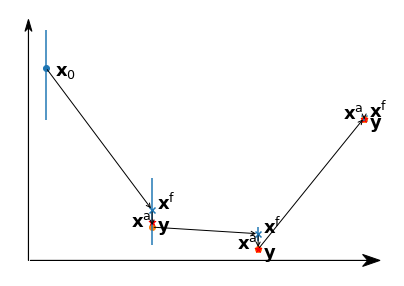

In [374]:
fig, ax = plt.subplots(figsize=[7, 5])
x = np.linspace(0, dt*nstop, nstop+1)
#wtrue = np.copy(xtrue)
#ax.plot(x, wtrue[:, 1])
xf = np.load("xf000.npy")
xf_max = np.amax(xf, axis=1)
xf_min = np.amin(xf, axis=1)
xf_mean = np.mean(xf, axis=1)
ax.set_prop_cycle(None)
yerr = np.abs(np.array((xf_min[1], xf_max[1]))[:, None] - xf_mean[1])
ax.errorbar(0, xf_mean[1], yerr)
ax.scatter(0, xf_mean[1])
xf_old = xf_mean[1]
told = 0
ax.text(0.05, xf_mean[1]-2, "$\mathbf{x}_0$", size=18)
for j in range(nstop//obs_int):
    ax.set_prop_cycle(None)
    xf = np.load(f"xf{obs_int*(j+1):03}.npy")
    xf_max = np.amax(xf, axis=1)
    xf_min = np.amin(xf, axis=1)
    xf_mean = np.mean(xf, axis=1)
    xa = np.load(f"xa{obs_int*(j+1):03}.npy")
    xa_mean = np.mean(xa, axis=1)
    t = obs_int*(j+1) * dt
    tnmem = [t] * nmem
    yerr = np.abs(np.array((xf_min[1], xf_max[1]))[:, None] - xf_mean[1])
    ax.scatter(t, xf_mean[1], marker="x")
    ax.errorbar(t, xf_mean[1], yerr)
    ax.scatter(t, xa_mean[1])
    ax.scatter(t, xtrue[obs_int*(j+1), 1], marker="*", s=50, c="red")
    ax.annotate(text="", xy=(t, xf_mean[1]), xytext=(told, xf_old),
               arrowprops=dict(arrowstyle="->"))
    ax.annotate(text="", xy=(t, xa_mean[1]), xytext=(t, xf_mean[1]),
               arrowprops=dict(arrowstyle="->"))
    ax.text(t+0.03, xf_mean[1], "$\mathbf{x}^\mathrm{f}$", ma="center", size=18)
    ax.text(t-0.12, xa_mean[1], "$\mathbf{x}^\mathrm{a}$", ma="center", size=18)
    ax.text(t+0.03, xtrue[obs_int*(j+1), 1]-2, "$\mathbf{y}$", ma="center", size=18)
    xf_old = xa_mean[1]
    told = t

ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.spines[:].set_visible(False)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
dx = (xmax - xmin)
dy = (ymax - ymin)
lw = 1.0
ohg = 0.3
ax.arrow(xmin, ymin, dx, 0, color="k",
        head_width=dy*0.05, head_length=dx*0.05, overhang=ohg,
        length_includes_head=True, clip_on=False)
ax.arrow(-0.1, ymin, 0, dy, color="k",
        head_width=dx*0.02, head_length=dy*0.05, overhang=ohg,
        length_includes_head=True, clip_on=False)
plt.show()

予報誤差共分散はアンサンブル摂動から作ります。

$$
\mathbf{P}_\mathrm{f} = \frac{1}{N_\mathrm{E}}\delta\mathbf{X}\delta\mathbf{X}^T\label{Pf}
$$

$\delta\mathbf{X}$の$j$番目の列ベクトルは，アンサンブルメンバーの摂動（アンサンブル平均からのずれ）$\mathbf{x}_\mathrm{f}^{(j)}-\bar{\mathbf{x}}_\mathrm{f}$です。
観測は変数毎にあらかじめ定めた観測誤差標準偏差を用いて，正規乱数でメンバー毎に異なる誤差を加えます。

$$
\mathbf{y}^{(i)} = \mathbf{y} + \boldsymbol{\varepsilon}^{(i)}
$$

状態変数が3つしかありませんので，カルマンゲインは{eq}`n-form`を使います。
解析は{eq}`xa`でアンサンブル平均を解析値とします。

:::{admonition} EnKF (PO)によるデータ同化
1. 初期値に摂動を加えたアンサンブルを作成する。
2. アンサンブル予報を行う。
3. アンサンブル平均と摂動を求め，予報誤差共分散を計算する。
4. 観測演算子と観測誤差共分散，予報誤差共分散からカルマンゲインを計算する。
5. メンバー毎に異なる摂動を加えた観測とアンサンブル予報との差（イノベーション）を計算する。
6. アンサンブル予報，カルマンゲイン，イノベーションから解析アンサンブルを計算し，次の予報の初期アンサンブルとする。
:::

In [239]:
def po(xf, yo, rmat, hmat):
    dx = xf - np.mean(xf, axis=1)[:, None]
    pf = dx @ dx.transpose() / (nmem - 1)
    ic = hmat @ pf @ hmat.transpose() + rmat
    kmat = pf @ hmat.transpose() @ np.linalg.inv(ic)   
    xa = xf + kmat @ (yo - hmat @ xf)
    return xa

def run_ens(xf, p, r, b, nstop):
    _, nmem = xf.shape
    for i in range(nmem):
        w = xf[:, i]
        for k in range(nstop):
            w += dt * florenz(w, p, r, b)
        xf[:, i] = w           
    return xf

以下の実験では一つの状態変数$y$の符号を反転させています。
アンサンブル予報には標準偏差`xs`の正規乱数を加えて加法的に共分散を膨張させています。
共分散膨張（インフレーション）と呼ばれる手法は，予報誤差共分散が小さくなりアンサンブルで場を表現できなくなることを避けるために用いられます。

変分法と同化ウィンドウ同じ期間に対して，逐次データ同化を行います。
観測の間隔のアンサンブル予報と解析を繰り返しています。
誤差を与える前の観測には真値を用いています。

In [246]:
nmem = 3
xs = 3.0
nstop = 200
obs_int = 60

hmat = np.eye(w.size)
rmat = np.diag(e**2)

xtrue = np.load("xt.npy")
w = np.array([1, -3, 5])
rng = np.random.default_rng()
xf = np.zeros([w.size, nmem])
for i in range(w.size):
    xf[i, :] = w[i, None] + xs * rng.standard_normal(nmem)
np.save("xf000.npy", xf)
yo = np.zeros([w.size, nmem])
for j in range(nstop//obs_int):
    for i in range(w.size):
        yo[i, :] = xtrue[obs_int*(j+1), i] + e[i] * rng.standard_normal(nmem)
    xf = run_ens(xf, p, r, b, obs_int)
    np.save(f"xf{obs_int*(j+1):03}.npy", xf)
    xa = po(xf, yo, rmat, hmat)
    np.save(f"xa{obs_int*(j+1):03}.npy", xa)
    xf = xa

結果を図示してみましょう。
真値を曲線，個々の予報を点で，予報アンサンブル平均を$\times$，解析値（解析アンサンブル平均）を$\color{red} \bullet$で表します。
最初のアンサンブル予報では，誤った初期値から開始した$y$のアンサンブルスプレッドが増加しています。
観測が同化されるにつれアンサンブルが縮小し，予報値と解析値が真値に近づいています。

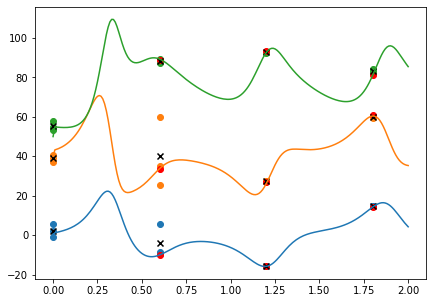

In [247]:
off = 0, 40, 50

x = np.linspace(0, dt*nstop, nstop+1)
wtrue = np.copy(xtrue)
wtrue[:, 1] += off1            
wtrue[:, 2] += off2
fig, ax = plt.subplots(figsize=[7, 5])
ax.plot(x, wtrue)
xf = np.load("xf000.npy")
xf_mean = np.mean(xf, axis=1)
ax.set_prop_cycle(None)
for i in range(len(off)):
    ax.scatter([0]*nmem, xf[i, :] + off[i])
for i in range(len(off)):
    ax.scatter(0, xf_mean[i] + off[i], c="black", marker="x")
for j in range(nstop//obs_int):
    ax.set_prop_cycle(None)
    xf = np.load(f"xf{obs_int*(j+1):03}.npy")
    xf_mean = np.mean(xf, axis=1)
    xa = np.load(f"xa{obs_int*(j+1):03}.npy")
    xa_mean = np.mean(xa, axis=1)
    t = obs_int*(j+1) * dt
    tnmem = [t] * nmem
    for i in range(len(off)):
        ax.scatter(tnmem, xf[i, :] + off[i])
    for i in range(len(off)):
        ax.scatter(t, xa_mean[i] + off[i], c="red")
    for i in range(len(off)):
        ax.scatter(t, xf_mean[i] + off[i], c="black", marker="x")

## ニューラルネットワーク

ニューラルネットワークは，回帰や分類に用いられる数理モデルで人工知能に応用されています。
この章の初めに[回帰分析](regression)を学びました。
ニューラルネットワークもデータに適合する重みを求めます。
線型回帰とは異なり，入力と出力との間に中間層（隠れ層）を配置し線型結合に対して活性化函数を用いることにより，非線型な関係を表現することが可能です。
中間層は複数重ねることができ，ニューラルネットワークは多層パーセプトロン（multilayer perceptron, MLP）とも呼ばれています。
中間層を多段に（深く）したものが深層学習です。
生体中の情報伝達の数理モデルとして考案されたことから，ニューラルネットワークと呼ばれています。
各層の節をニューロンに見立て，刺激によりニューロンが発火すると情報が伝達されます。

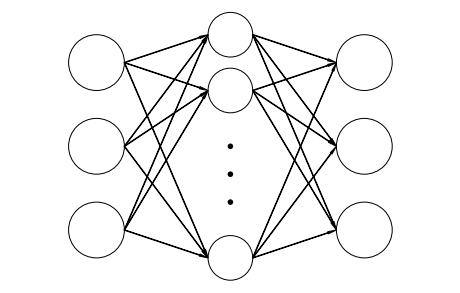

In [64]:
アンサンブルカルマンフィルタimport matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrow
from math import sqrt

fig, ax = plt.subplots(figsize=[8,8])
ax.set_xlim([0.0, 1.6])

r = 0.1
x = [0.32, 1.28]
for j in range(2):
    for i in range(3):
        c = Circle((x[j], 0.3*i+0.2), r, fill=False)
        ax.add_patch(c)

r = 0.08
y = [0.1, 0.7, 0.9]
for i in range(3):
    c = Circle((0.8, y[i]), r, fill=False)
    ax.add_patch(c)

r = 0.01
for i in range(3):
    c = Circle((0.8, 0.1*i+0.3), r, fc="black")
    ax.add_patch(c)

w = 0.002
for j in range(3):
    for i in range(3):
        y0 = 0.3*j + 0.2
        a = FancyArrow(0.42, y0, 0.3, y[i]-y0, w, color="black",
            head_width=w*4, head_length=w*16, length_includes_head=True)
        ax.add_patch(a)

for j in range(3):
    for i in range(3):
        y0 = 0.3*j + 0.2
        a = FancyArrow(0.88, y[i], 0.3, y0-y[i], w, color="black",
            head_width=w*4, head_length=w*16, length_includes_head=True)
        ax.add_patch(a)

ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.spines[:].set_visible(False)
ax.set_aspect(1)
plt.show()

ここでは，情報が入力から出力に伝わる順伝播型（feed forward, forward propagation）のニューラルネットワークを用います。
図の一番左，真ん中，右の円は，それぞれ入力層，中間層，出力層の節を表しています。
節間の結合は重みで表され，データから推定されます。
矢印の向きの通り，情報が入力から出力に向かって進みます。
入力$\mathbf{x}$，隠れ層$(1)$，出力層$(2)$の活性化函数をそれぞれ$h, \sigma$，バイアスを$\mathbf{b}^{(1)}, \mathbf{b}^{(2)}$とすると，
出力$\mathbf{y}$は
\begin{equation}
\mathbf{y}=\sigma\left[\mathbf{W}^{(2)}h\left(\mathbf{W}^{(1)}\mathbf{x}+\mathbf{b}^{(1)}\right)+\mathbf{b}^{(2)}\right]
\end{equation}
と表すことができます。
なお，バイアスは図からは省略されています。

順伝播ニューラルネットワークでは，重みを最適化する際に計算される評価函数の勾配は，数値微分により計算されます。
大規模な問題では，効率よく勾配を計算するため，変分法データ同化における随伴法に対応する誤差逆伝播法が用いられます。
隠れ層には次元縮約のため主成分分析などを組み込んだり，特定のパターンに反応する畳み込み層を用いたりすることもあります。

Lorenz-63モデルをscikit-learnのニューラルネットワークを使って学習させてみましょう。

まずニューラルネットワークを作りましょう。
入力は`StandardScaler`で正規化し，入力層と出力層との間にMLP回帰を行う中間層`MLPRegressor`を配置します。
隠れ層の節の数`hidden_layer_sizes`の既定値は100ですが，ここでは20にします。
`make_pipeline`を用いて正規化とMLP回帰からなるニューラルネットワークを構成します。

In [95]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

nh = 25
nn = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=[nh]))

Lorenz-63モデルを10000ステップ積分し，学習及び検証のためのデータを作成します。
学習に用いる教師データは全体の7割とすることが多いようです。

In [96]:
from scipy.integrate import odeint


p, r, b, dt, nstop = 10.0, 32.0, 8/3, 0.01, 10000
w0 = np.array([1.0, 3.0, 5.0])
w1 = np.copy(w0)

def florenz_(w, t, p, r, b):
    return florenz(w, p, r, b)

w = odeint(florenz_, w1, np.linspace(0, 100, 10001), args=(p, r, b))

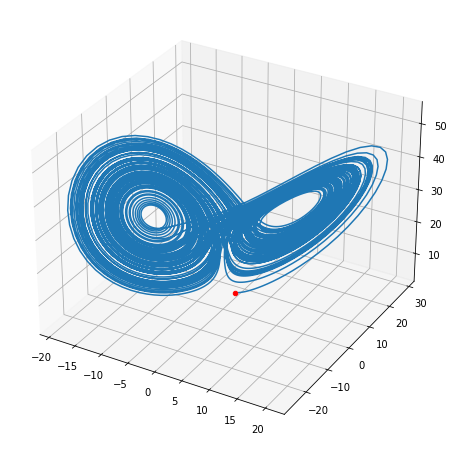

In [106]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(projection="3d")
ax.scatter(*w[0,:], c="red")
ax.plot(*w.transpose())
plt.show()

Lorenz-63モデルは3変数なので，入力層は3つの節$\dot{x}, \dot{y}, \dot{z}$で構成されます。
モデル自体を推定するので，出力層も$\dot{x}, \dot{y}, \dot{z}$です。
学習は`fit()`メソッドを呼び出すことにより行います。

In [98]:
dwdt = (w[1:] - w[:-1]) / dt
n_learn = int(nstop * 0.7)
nn.fit(w[1:n_learn+1], dwdt[0:n_learn])

/opt/local/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor', MLPRegressor(hidden_layer_sizes=[25]))])

初期値からの1ステップ予報を比較してみます。予測には`predict()`メソッドを呼び出します。一度にまとめて複数の入力を与えることができように，引数は2次元になっていることに注意してください。

In [99]:
w0  + dt * nn.predict(w0[None,])

array([[1.1178829 , 3.35067441, 5.23629434]])

In [100]:
w[1,]

array([1.20279516, 3.26650983, 4.90248242])

予報モデルと推定されたモデルの時間変化傾向$\dot{x}, \dot{y}, \dot{z}$を散布図で比較します。

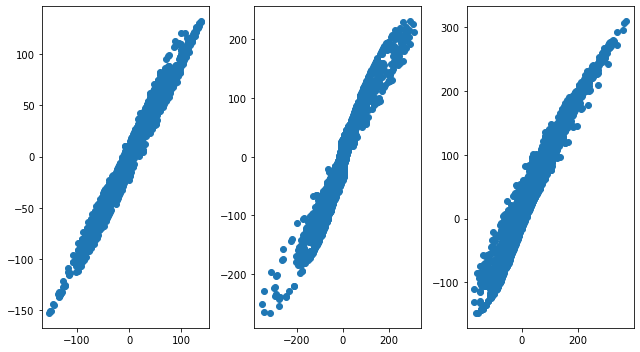

In [101]:
dwdt_nn = nn.predict(w[n_learn:-1])

fig, ax = plt.subplots(ncols = 3, figsize=[9, 5])
for i in range(w0.size):
    ax[i].scatter(dwdt[n_learn:, i], dwdt_nn[:, i])
fig.tight_layout()
plt.show()

検証データにおける相対誤差は21%くらいになりました。

In [103]:
np.linalg.norm(dwdt[n_learn:,:]-dwdt_nn) / np.linalg.norm(dwdt[n_learn:,:])

0.21077661359595465

推定されたモデルを時間積分して図示してみると，Lorenz-63モデルに似た軌道をとるモデルが推定できたようです。
隠れ層の節の数が少ないと周期解になってしまいます。

In [104]:
from scipy.integrate import odeint

def florenz_nn(x, args):
    return nn.predict(x[None,]).ravel()

w_nn = odeint(florenz_nn, w0, np.linspace(0, 100, 10001))

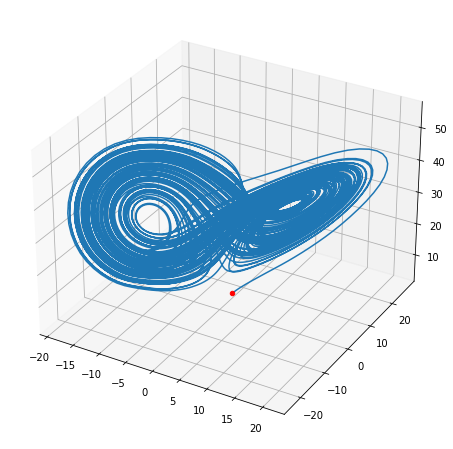

In [107]:
fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(projection="3d")
ax.scatter(*w0, c="red")
ax.plot(*w_nn.transpose())
plt.show()

Lorenz-63の場合はモデルが分かっていますが，支配方程式系がよく分からないときや非常に複雑なときにニューラルネットワークは力を発揮します。
気象では支配方程式系が分かっていますが，相互作用が複雑で第一原理計算が膨大になる過程が含まれています。
モデルの格子スケール以下の物理パラメタリゼーション，雲画像から熱帯低気圧強度の推定，循環パターンの分類，大気の不確実性の予測など気象学の様々な分野に機械学習の応用が試みられており，今後更なる発展が期待されます。